In [1]:
import os
import base64
import matplotlib.pyplot as plt
from mistralai import Mistral
import json
import pandas as pd
from typing import Union
import numpy as np
import secrets
import time
from concurrent.futures import ThreadPoolExecutor

pd.set_option('display.max_colwidth', None)
# Load Mistral API key from environment variables
api_key = "ZL4LdkeCwsoIYcNx2aFDujTYgpwj2kij"
# Initialize the Mistral client
client = Mistral(api_key=api_key)

### Generate wardrobes from database

In [2]:
def img_to_base64(image_path):
    """Input : image_path (str) : path to the image file
    Returns : image_base64 (str) : base64 encoded image"""
    
    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()

    image_base64 = base64.b64encode(image_bytes).decode('utf-8')
    
    return image_base64

def json_to_dataframe(json_data: Union[str, dict], key: str = None) -> pd.DataFrame:
    # If json_data is a string, parse it into a dictionary
    if isinstance(json_data, str):
        json_data = json.loads(json_data)
    
    # If a key is provided, extract the list of records from the JSON object
    if key is not None:
        data = json_data[key]
    else:
        data = json_data
    
    # Convert the list of records to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

def list_clothes(args): 
    image_base64, guide = args
    time.sleep(1)
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"elements\": [{\"element\": \"some name for element1\", "
                    "\"color\": \"the color of element1\", "
                    "\"fit\": \"the fit, shape of element1. Be concise.\", "
                    "\"price\": \"some number, estimated price of element1\", "
                    "\"context\": \"a word describing the occasion, mood or functionality of the piece\", "
                    "\"description\": \"a description of element1, emphasizing on the vibe of the piece and that encapsulates the precedent variables\"}, "
                    "{\"element\": \"some name for element2\", ...}]}"
        },
        {
            "role": "system",
            "content": f"You are a fashion critique, neutral and objective.\n\n {guide} \n\n You are presented with an image of an outfit, describe each of the elements thanks to your expertise "
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": f"data:image/jpeg;base64,{image_base64}"
                }
            ]
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model="pixtral-12b-2409",
        messages=messages,
        temperature=0.4,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content


In [3]:
desc_guide_path = "./desc_guide.txt"
critique_guide_path = "./critique_guide.txt"

with open(critique_guide_path, "rb") as f:
    critique_guide = f.read()

with open(desc_guide_path, "r") as f:
    desc_guide = f.read()

In [4]:
n_images=15
all_images = os.listdir("C:/Users/bapti/Documents/DATA/Cours/3A/Hackathon/fashion_images_dataset/")
n_images = np.random.choice(all_images, n_images, replace=False)
print(n_images)

['0970.jpg' '1073.jpg' '1090.jpg' '0369.jpg' '1272.jpg' '0693.jpg'
 '1995.jpg' '0525.jpg' '0859.jpg' '1418.jpg' '0017.jpg' '0689.jpg'
 '1899.jpg' '1357.jpg' '0949.jpg']


In [5]:
args_clothes = [(img_to_base64("C:/Users/bapti/Documents/DATA/Cours/3A/Hackathon/fashion_images_dataset/"+img), desc_guide) for img in n_images]

# Using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=8) as executor:
    # Submit tasks and collect results
    Wardrobes = list(executor.map(list_clothes, args_clothes))

### Suggest from wardrobe

In [140]:
def process_critique(args):
    time.sleep(1)
    wardrobe, guide, model = args
    
    chat_response = client.chat.complete(
        model=f"mistral-{model}-latest",
        messages=[
            {"role": "system", "content": f"As a 'Fashion Critique', your mission is to help relook people. \n\n {guide} \n\n You are given a description of items in an outfit. Give a critique of the outfit, outlining the general vibe, how the pieces work together and what could be improved."},
            {"role": "user", "content": '-'+'\n-'.join(wardrobe['description'])},
        ],
        temperature=0.2,
        max_tokens=2048
    )
    result = chat_response.choices[0].message.content

    return result

def recommend_item(args):
    time.sleep(1) 
    critique, guide, color_rule, piece_rule, element, model = args  
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"elements\": [{\"element\": \"some short name for element1\", "
                    "\"color\": \"the color of element1\", "
                    "\"fit\": \"the fit, shape of element1\", "
                    "\"price\": \"some number, estimated price of element1\", "
                    "\"context\": \"a word describing the occasion, mood or functionality of the piece\", "
                    "\"description\": \"a description of element1, emphasizing on the vibe of the piece and that encapsulates the precedent variables\"}]}"
        },
        {
            "role": "system",
            "content": f"You are a fashion critique, neutral and objective.\n\n {guide} \n\n You are presented with a critique of an outfit, describe a single element that would improve the outfit."
        },
        {
            "role": "system",
            "content": "Follow this rule when suggesting a piece of clothing: " + piece_rule
        },
        {
            "role": "system",
            "content": "Follow this rule when choosing a color: " + color_rule
        },
        {
            "role": "system",
            "content": "You will have to strictly follow these constraints when designing the item :" + str(element)
        },
        {
            "role": "user",
            "content": critique
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model=f"mistral-{model}-latest",
        messages=messages,
        temperature=0.4,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content

def recommend_from_wardrobe(args):
    time.sleep(1)
    wardrobe, element, critique_guide, desc_guide = args
    model="large"
    color_rules = np.random.choice([ 
                                "complementary colors: colors that are opposite on the color wheel", 
                                "analogus colors: colors that are close on the color wheel", 
                                "accent color: one bright color that pops from the rest that are neutral", 
                                "sandwiching: layering a bright color between two neutral colors",
                                "monochromatic: using different shades of the same color to create a cohesive look",
                                "pattern mixing: combining different patterns to create a unique outfit",
                                "seasonal: using seasonal colors and pieces to create a weather-appropriate outfit",
                                            ])
            
    piece_rules = np.random.choice([
                                    "mixing textures: incorporating different textures to add visual interest",
                                    "statement piece: building an outfit around a bold statement piece",
                                    "proportion balance: suggest a piece with a fit that balances the outfit", 
                                    "accessories: adding an accessory to elevate the outfit",
                                    "silouhette: creating a visually interesting shape with the outfit",
                                    "replacement: suggesting a piece that would replace a current piece in the outfit",
                                    "layering: adding a layer to the outfit to create depth, like a coat or jacket",
                                    "adding surface: suggest a pig piece with a different surface, like a shiny or matte fabric"
                                        ])
    
    critique = process_critique((wardrobe, critique_guide, model))
    content = recommend_item((critique, desc_guide, color_rules, piece_rules, element, model))
    
    return content

In [ ]:
element = {"element":None, "color":None, "fit":None, "price":None, "context":None, "description":None}
print(str(element))
img=6
wardrobe_df = json_to_dataframe(Wardrobes[img],key='elements')
content_large = recommend_from_wardrobe((wardrobe_df, element, critique_guide, desc_guide))
content_df = json_to_dataframe(content_large, key='elements')

{'element': None, 'color': None, 'fit': None, 'price': None, 'context': None, 'description': None}


TypeError: list indices must be integers or slices, not str

,element,color,fit,price,context,description
0,Denim Shirt,Navy Blue,"Relaxed, slightly oversized",Estimated $50-$80,"Casual, everyday wear","A classic navy blue denim shirt with a relaxed fit, perfect for casual, everyday wear. The shirt features button-down details and a casual, laid-back vibe."
1,High-Waisted Trousers,Black,"Loose, cropped at the ankle",Estimated $70-$120,"Casual, urban setting","High-waisted black trousers with a loose, cropped fit at the ankle, ideal for a casual, urban setting. The trousers complement the denim shirt, creating a balanced and stylish look."
2,Belt,Brown,"Fitted, cinches the waist",Estimated $30-$60,"Casual, everyday wear","A brown belt that cinches the waist, adding a touch of structure to the casual outfit. The belt complements the earthy tones of the ensemble and enhances the overall style."
3,Clutch Bag,Black with Gold Detailing,"Compact, functional",Estimated $60-$100,"Urban, casual setting","A compact black clutch bag with gold detailing, perfect for an urban, casual setting. The bag adds a touch of elegance to the outfit while remaining functional and stylish."
4,Brown Leather Shoes,Brown,"Comfortable, classic design",Estimated $80-$150,"Casual, everyday wear","Brown leather shoes with a classic design, providing comfort and style for everyday wear. These shoes complement the earthy tones of the outfit and add a touch of sophistication."


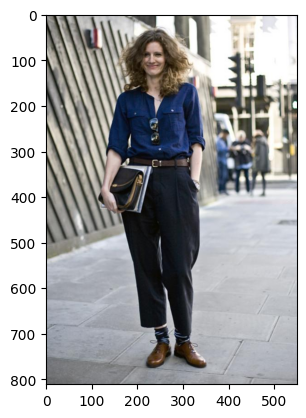

In [160]:
plt.imshow(plt.imread("C:/Users/bapti/Documents/DATA/Cours/3A/Hackathon/fashion_images_dataset/"+n_images[img]))
wardrobe_df

In [161]:
content_df

,element,color,fit,price,context,description
0,Patterned Scarf,Vibrant multicolored,"Versatile, can be worn as a belt or draped around the neck",45,Urban chic,"A vibrant, patterned scarf that adds a pop of color and visual interest to the outfit. The scarf features a multicolored print with a silk-like fabric for a smooth, elegant feel. Its versatile fit allows it to be worn as a belt, accentuating the waist and creating a more defined silhouette, or draped around the neck for a casual, chic look. The scarf's bold colors and patterns complement the earthy tones of the belt and shoes, tying the ensemble together while introducing a dynamic, exciting element. Perfect for an urban setting, this accessory elevates the outfit's appeal and helps create a more refined and stylish urban chic aesthetic. The estimated price is $45."
